In [23]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')
from tensorflow import keras
import cv2
import urllib.request
import numpy as np
import random
import os
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from sklearn.model_selection import train_test_split
from keras import backend # backend -> tf/theano etc
#from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import GridSearchCV
#from keras.models import Sequential
#from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.models import Sequential # no parallel, no cycles 
from keras.losses import binary_crossentropy
%pylab inline
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense,Dropout, Flatten, Activation

Populating the interactive namespace from numpy and matplotlib


In [24]:
def url_to_image(url):
	# download the image, convert it to a NumPy array, and then read
	# it into OpenCV format
	resp = urllib.request.urlopen(url)
	image = np.asarray(bytearray(resp.read()), dtype="uint8")
	image = cv2.imdecode(image, cv2.IMREAD_COLOR)
	# return the image
	return image

In [4]:
animals = ['cats','dogs','rats','cheetah','cows','deer','ducks','elephants','foxes','giraffes','goats','hens','horses','lions','monkeys','parrots','pigs','sheep','tigers','fish','donkey','rabbit','catanddog','catandrat','tigerandlion','dogandsheep','henandcat','henanddog','horseandcat','horseanddog','monkeyandcat','monkeyanddog','parrotandcat','dogandrat','duckandcow','duckandcat','duckanddog','henandduck','rabbitandcat','rabbitanddog','pigandgoat','piganddog']
numbers = [598,594,592,599,599,591,601,597,598,600,595,600,599,599,600,594,601,599,598,599,602,599,295,300,150,147,148,143,149,149,151,149,149,248,145,149,148,147,147,146,149,147]

In [5]:
print(len(animals))
print(len(numbers))

42
42


In [6]:
containers = ['dogs','cats','rats','cheetah','cows','deer','ducks','elephants','foxes','giraffes','goats','hens','horses','lions','monkeys','parrots','pigs','sheep','tigers','fish','donkey','rabbit']
print(len(containers))

22


In [7]:
classes = {'dogs': 0,
'cats':1,
'rats':2,'cheetah' : 3,'cows': 4,'deer' :5 ,'ducks' : 6,'elephants' : 7,'foxes':8,'giraffes':9,'goats':10,'hens':11,'horses':12,'lions':13,'monkeys':14,'parrots':15,'pigs':16,'sheep':17,'tigers':18,'fish':19,'donkey':20, 'rabbit':21}

In [8]:
import time
data = []
labels = []
for i in range(len(animals)):
  for fname in range((numbers[i])):
    if len(str(fname))==3:
      path = 'https://animalsdataset.blob.core.windows.net/' + animals[i]+ '/' + str(fname) + '.jpg'
      try:
        image = url_to_image(path)
      except:
        continue
    if len(str(fname))==2:
      path = 'https://animalsdataset.blob.core.windows.net/' + animals[i] + '/0' + str(fname) + '.jpg'
      try:
        image = url_to_image(path)
      except:
        continue
    if len(str(fname))==1:
      path = 'https://animalsdataset.blob.core.windows.net/' + animals[i] + '/00' + str(fname) + '.jpg'
      try:
        image = url_to_image(path)
      except:
        continue
    try:
      imgdata = cv2.resize(image,(96,96))
      label = []
      for z in range(len(containers)):
        label.append(0)
      naming = []
      if 'and' in animals[i]:  
        names = animals[i].split('and')
        for w in range(len(names)):
          names[w] = names[w] + 's'
          naming.append(names[w])
      else:
        naming.append(animals[i])
      for t in range(len(naming)):
        label[classes[naming[t]]]=1   
      label = np.asarray(label)
      try:
        labels.append(label)
        data.append(imgdata)
      except:
        continue
    except:
      continue
 



In [9]:
print(len(labels))
print((len(data)))

15182
15182


In [10]:
norm_data = np.array(data, dtype='float') / 255 
labels = np.array(labels) 
trainx, testx, trainy, testy = train_test_split(norm_data,labels,test_size=0.2,random_state=42)

In [11]:
import keras.backend as K

def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0.0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

In [31]:
#HP_block5_dense_dim = 1024  ###remain as it is 
#HP_block_conv_dim = 1024

####just filters size 
HP_small_pattern = (3,3) 
HP_large_pattern = (2,2) 
#### 


#HP_epoch = 100
HP_init_lr = 1e-3 # learning_rate = 0.001
#HP_batch_size = 38
HP_image_dim = (96,96,3)
HP_Classes = len(classes)

In [37]:
class CorrectPandaVGG:
  def create(height, width, depth, classes,dropout_ratio = 0.4,HP_block_dim = 64):
    # assume that we are on TF, but if something else is detected, switch the dimension
    input_shape = (height, width, depth)
    channel_dim = -1 # last position 
    if backend.image_data_format() == 'channels_first':
      input_shape = (depth, height, width)
      channel_dim = 1
    model = Sequential()
    
    # BLOCK1
    model.add(Conv2D(HP_block_dim,HP_small_pattern, padding='same',
                     input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=channel_dim))
    model.add(MaxPooling2D(pool_size=HP_small_pattern))
    model.add(Dropout(dropout_ratio))

    # COMPLEX BLOCK 2
    model.add(Conv2D(HP_block_dim,HP_small_pattern, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=channel_dim))
    model.add(Conv2D(HP_block_dim,HP_small_pattern, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=channel_dim))
    model.add(MaxPooling2D(pool_size=HP_large_pattern))
    model.add(Dropout(dropout_ratio))
    
    # COMPLEX BLOCK 3
    model.add(Conv2D(HP_block_dim,HP_small_pattern, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=channel_dim))
    model.add(Conv2D(HP_block_dim,HP_small_pattern, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=channel_dim))
    model.add(MaxPooling2D(pool_size=HP_large_pattern))
    model.add(Dropout(dropout_ratio))

    # COMPLEX BLOCK 4
    model.add(Conv2D(HP_block_dim,HP_small_pattern, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=channel_dim))
    model.add(Conv2D(HP_block_dim,HP_small_pattern, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=channel_dim))
    model.add(MaxPooling2D(pool_size=HP_large_pattern))
    model.add(Dropout(dropout_ratio))

    # BLOCK 5- Image Classification (OBJECT)
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_ratio))

    model.add(Dense(classes))  
    model.add(Activation('sigmoid')) ############# final layers

    optimizer = Adam(lr=HP_init_lr, decay= HP_init_lr/100)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy',f1_score]) ### compiling before returning
    return model

In [39]:
trial_model = KerasClassifier(build_fn=CorrectPandaVGG.create)

In [38]:
####################   hyperparameter tuning  ############
batch_size = [25,32]
epochs = [25]
dropout_ratio = [0.3,0.4,0.5,0.6,0.7]
HP_block_dim = [64,128,256,512]
height = [96]
width = [96]
depth = [3]
classes = [22]
param_grid = dict(batch_size=batch_size, epochs=epochs, dropout_ratio = dropout_ratio,HP_block_dim = HP_block_dim, height = height, width = width, depth = depth,classes = classes)
grid = GridSearchCV(estimator=trial_model, param_grid=param_grid, cv=2,n_jobs = -1)

In [35]:
print(len(trainx))
print(len(trainy))
print(trainx[0].shape)
print(trainy[0].shape)

12145
12145
(96, 96, 3)
(22,)


In [40]:
grid_result = grid.fit(trainx, trainy)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Epoch 1/25
486/486 [==============================] - 97s 198ms/step - loss: 0.5900 - accuracy: 0.0578 - f1_score: nan
Epoch 2/25
486/486 [==============================] - 96s 198ms/step - loss: 0.2048 - accuracy: 0.1242 - f1_score: nan
Epoch 3/25
486/486 [==============================] - 96s 197ms/step - loss: 0.1923 - accuracy: 0.1836 - f1_score: nan
Epoch 4/25
486/486 [==============================] - 110s 226ms/step - loss: 0.1803 - accuracy: 0.2397 - f1_score: nan
Epoch 5/25
486/486 [==============================] - 110s 227ms/step - loss: 0.1729 - accuracy: 0.2649 - f1_score: nan
Epoch 6/25
486/486 [==============================] - 104s 215ms/step - loss: 0.1668 - accuracy: 0.3056 - f1_score: nan
Epoch 7/25
486/486 [==============================] - 96s 197ms/step - loss: 0.1613 - accuracy: 0.3216 - f1_score: nan
Epoch 8/25
486/486 [==============================] - 96s 198ms/step - loss: 0.1558 - accuracy: 0.3481 - f1_score: nan
Epoch 9/25
486/486 [=========================

In [21]:
model = CorrectPandaVGG.create(96, 96, 3,HP_Classes,0.3,64) 

In [22]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, height_shift_range=0.1,
                         shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')


In [41]:
history = model.fit(aug.flow(trainx, trainy, batch_size=25), 
                              validation_data=(testx,testy),
                              steps_per_epoch = len(trainx)/25,
                              epochs=100)

Epoch 1/100
485/485 [==============================] - 105s 216ms/step - loss: 0.1636 - accuracy: 0.3188 - f1_score: nan - val_loss: 0.1578 - val_accuracy: 0.3237 - val_f1_score: 0.2578
Epoch 2/100
485/485 [==============================] - 105s 215ms/step - loss: 0.1596 - accuracy: 0.3328 - f1_score: nan - val_loss: 0.1847 - val_accuracy: 0.2542 - val_f1_score: nan
Epoch 3/100
485/485 [==============================] - 105s 215ms/step - loss: 0.1552 - accuracy: 0.3452 - f1_score: nan - val_loss: 0.1581 - val_accuracy: 0.3359 - val_f1_score: nan
Epoch 4/100
485/485 [==============================] - 105s 216ms/step - loss: 0.1536 - accuracy: 0.3541 - f1_score: nan - val_loss: 0.1453 - val_accuracy: 0.3862 - val_f1_score: 0.3052
Epoch 5/100
485/485 [==============================] - 105s 216ms/step - loss: 0.1496 - accuracy: 0.3775 - f1_score: nan - val_loss: 0.1554 - val_accuracy: 0.3563 - val_f1_score: 0.2736
Epoch 6/100
485/485 [==============================] - 104s 215ms/step - los

In [27]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

In [26]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# # evaluate loaded model on test data
# loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# score = loaded_model.evaluate(X, Y, verbose=0)

Loaded model from disk


In [28]:
classes = {0:'dogs',
1:'cats',
2:'rats', 3:'cheetah', 4:'cows', 5:'deer', 6:'ducks', 7:'elephants', 8:'foxes', 9:'giraffes', 10: 'goats', 11: 'hens', 12:'horses', 13:'lions', 14:'monkeys', 15:'parrots', 16:'pigs', 17:'sheep', 18:'tigers', 19:'fish', 20:'donkey', 21:'rabbit'}

(22,)


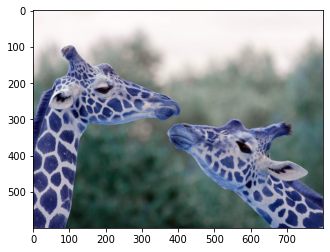

['giraffes']
finised
(22,)


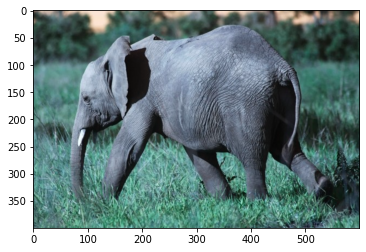

['elephants']
finised
(22,)


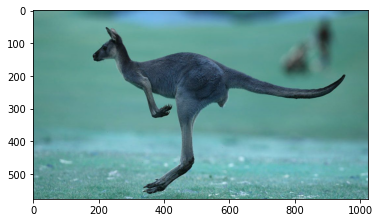

Not found
finised
(22,)


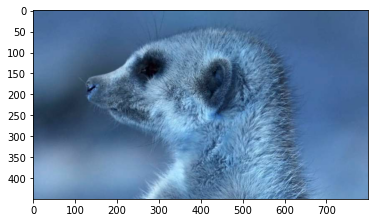

['cats']
finised
(22,)


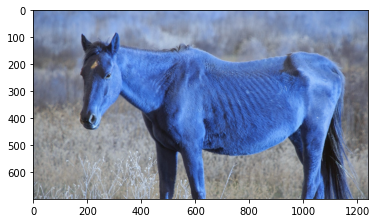

['horses']
finised
(22,)


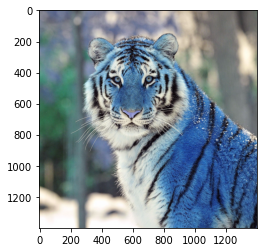

['tigers']
finised
(22,)


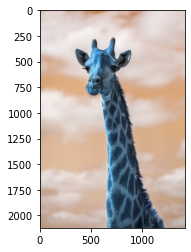

['giraffes']
finised


In [39]:
for fname in range(14):
    lists = []
    path = 'https://animalsdataset.blob.core.windows.net/animal'  + '/00' + str(fname) + '.jpg'
    try:
        image = url_to_image(path)
        imgdata = cv2.resize(image,(96,96))
        imgdata = imgdata.reshape(1,96,96,3)
        norm_data = np.array(imgdata, dtype='float') / 255     
        result = loaded_model.predict(norm_data)
        result = result.reshape(22)
        for i in range(len(result)):
            if result[i] >0.4:
                lists.append(classes[i])
        imgplot = plt.imshow(image)
        plt.show()
        if len(lists)>0:
            print(lists)
        else:
            print("Not found")
    except:
        continue